In [2]:
# Load necessary libraries for data manipulation, visualization, and modeling
library(repr)
library(tidyverse)
library(tidymodels)
library(kknn)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ broom        1.0.6      ✔ rsample      1.2.1 
✔ dials        1.2.1      ✔ tune         1.2.1 
✔ infer        1.0.7      ✔ workflows    1.1.4 
✔ modeldata    1.4.0      ✔ workflowsets 1.1.0 
✔ parsnip      1.2.1      ✔ yardstick    1.3.1 
✔ recipes      1.0.10     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ 

In [3]:
# Set options for maximum rows to display in matrices, useful for controlling output in notebooks
options(repr.matrix.max.rows = 10)

# Define a function to display digit images from a 28x28 pixel matrix
show_digit = function(arr784, col = gray(12:1 / 12), ...) {
  arr784$X <- 0  # avoid dark pixel in top left
  image(matrix(as.matrix(arr784[-785]), nrow = 28)[, 28:1], col = col, ...)
}

In [4]:
# Read training and testing data from CSV files
training_data <- read_csv('data/train.csv')
testing_data  <- read_csv('data/test.csv')
training_labels <- read_csv('data/train_label.csv')['y'] |> 
mutate(y = as_factor(y))
testing_labels  <- read_csv('data/test_label.csv')['y'] |> 
mutate(y = as_factor(y))

Rows: 600 Columns: 785
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (785): X, X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14, X...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 600 Columns: 785
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (785): X, X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14, X...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 600 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (2): X, y

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 

In [5]:
# Calculate and display the number of rows in the training labels
number_of_rows<-nrow(training_labels)
number_of_rows

# Calculate and display the counts of each unique label in the training labels
counts<-training_labels|>
group_by(y)|>
summarize(count=n())
counts

[1] 600

y,count
<fct>,<int>
0,58
1,69
2,64
3,59
4,59
5,56
6,54
7,62
8,54


y
<fct>
2


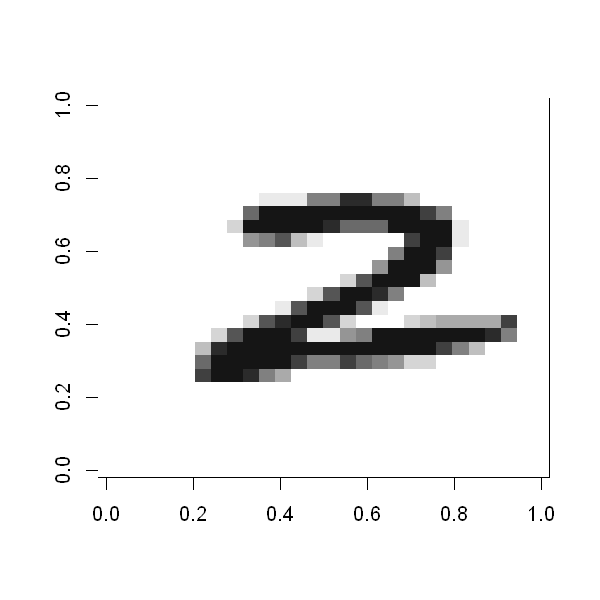

In [6]:
# Display the 200th digit from the training data
options(repr.plot.height = 5, repr.plot.width = 5)
show_digit(slice(training_data, 200))
training_labels |> 
    slice(200)

In [7]:
# Combine training data and training labels into a single data frame
set.seed(666) 
training_set<-bind_cols(training_data,training_labels)|>
select(-X)
testing_set<-bind_cols(testing_data, testing_labels)
head(training_set,3)
head(testing_set,3)

X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X776,X777,X778,X779,X780,X781,X782,X783,X784,y
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,5
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,4


X,X1,X2,X3,X4,X5,X6,X7,X8,X9,⋯,X776,X777,X778,X779,X780,X781,X782,X783,X784,y
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,7
2,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,2
3,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,1


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.7902801,5,0.02091733,Preprocessor1_Model01
3,accuracy,multiclass,0.8001425,5,0.01856929,Preprocessor1_Model02
4,accuracy,multiclass,0.8051155,5,0.01781245,Preprocessor1_Model03
5,accuracy,multiclass,0.8034077,5,0.01130724,Preprocessor1_Model04
6,accuracy,multiclass,0.7951012,5,0.01117836,Preprocessor1_Model05
⋮,⋮,⋮,⋮,⋮,⋮,⋮
11,accuracy,multiclass,0.7665169,5,0.01783102,Preprocessor1_Model10
12,accuracy,multiclass,0.7531962,5,0.02098945,Preprocessor1_Model11
13,accuracy,multiclass,0.7448897,5,0.02345486,Preprocessor1_Model12


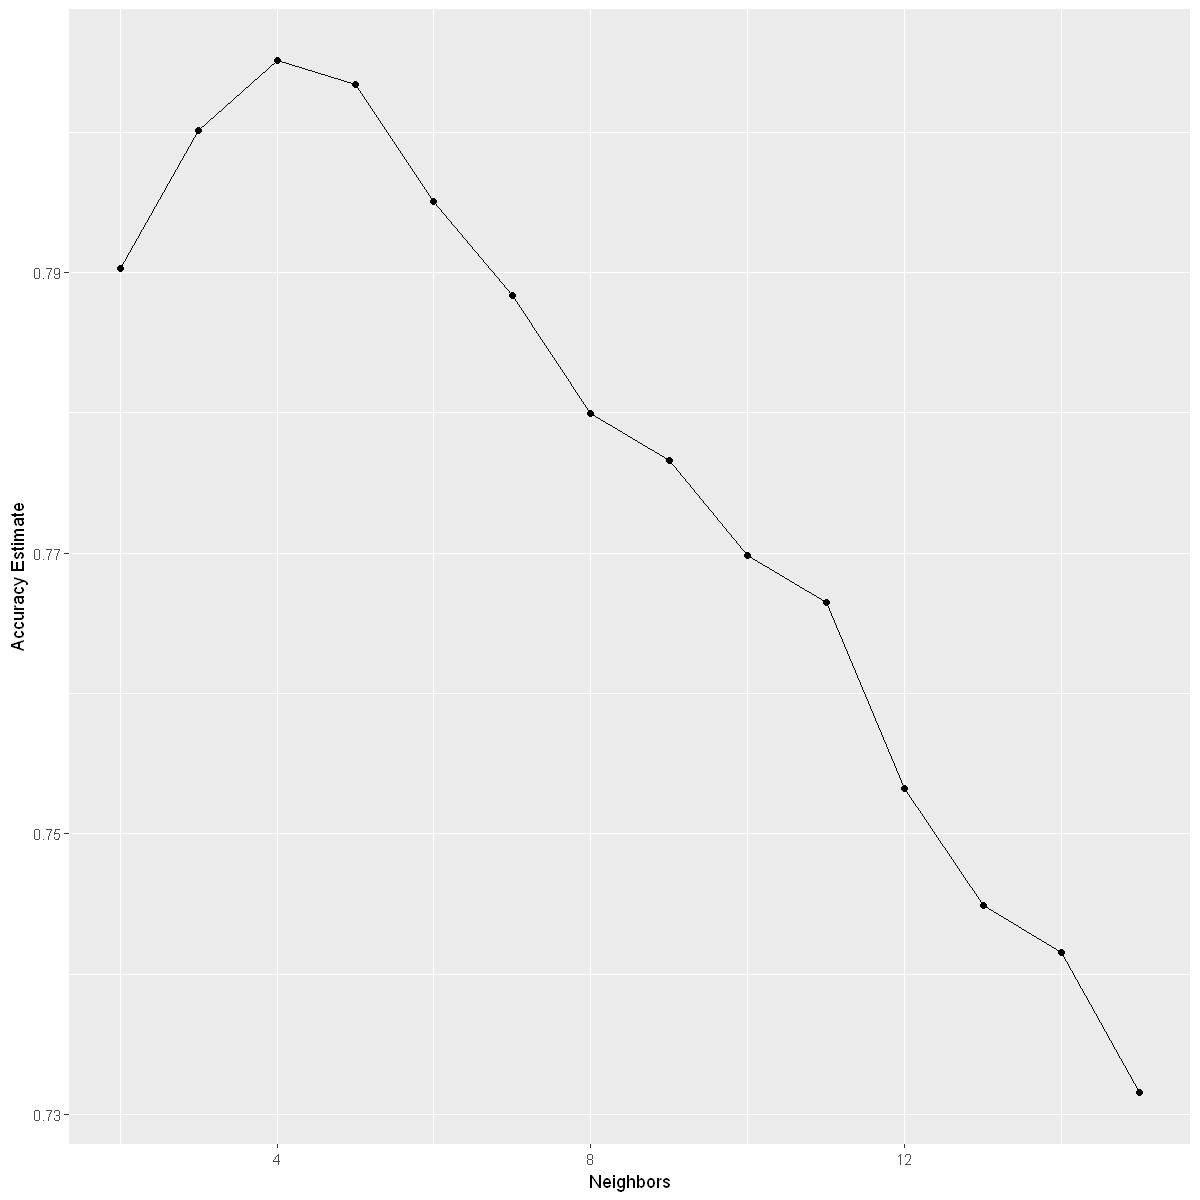

In [8]:
set.seed(666) 
# Create a recipe for preprocessing the training data
training_recipe <- recipe(y ~ .,data = training_set)

# Create cross-validation folds for the training set
training_vfold <- vfold_cv(training_set, v = 5, strata = y)

# Define the k-Nearest Neighbors model for tuning
knn_tune<-nearest_neighbor(weight_func="rectangular",neighbors=tune())|>
      set_mode("classification")|>
      set_engine("kknn")

# Define the grid of k values (number of neighbors) to be tested
k_vals <- tibble(neighbors =c(2:15))

#Create a workflow, add the recipe and model, perform grid search tuning with cross-validation,
knn_metrics <- workflow() |>
      add_recipe(training_recipe) |>
      add_model(knn_tune) |>
      tune_grid(resamples = training_vfold, grid=k_vals)|>
      collect_metrics()

# Filter for accuracy metrics
accuracies <- knn_metrics |> 
      filter(.metric=="accuracy")

accuracies

# Identify the top performing number of neighbors
top_k<-accuracies|>
arrange(-mean)|>
slice_head()|>
select(neighbors)|>
pull()

# Create a plot for cross-validation results
options(repr.plot.height = 10, repr.plot.width = 10)
cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate")
cross_val_plot

In [9]:
set.seed(666) 
# Define the final k-Nearest Neighbors model using the top-performing number of neighbors
knn_spec<-nearest_neighbor(weight_func="rectangular",neighbors=top_k)|>
set_mode("classification")|>
set_engine("kknn")

# Create a workflow, add the model specification and recipe, and fit the model to the training data
knn_fit<-workflow()|>
add_model(knn_spec)|>
add_recipe(training_recipe)|>
fit(training_set)

# Generate predictions on the testing set
knn_predictions<-predict(knn_fit,testing_set)|>
bind_cols(testing_set)

# Calculate and display accuracy metrics for the predictions
knn_metrics<-knn_predictions |>
  metrics(truth = y, estimate = .pred_class) |>
  filter(.metric == "accuracy")
knn_metrics

# Generate and display the confusion matrix for the predictions
knn_conf_mat <- knn_predictions |>
  conf_mat(truth = y, estimate = .pred_class)
knn_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7383333


          Truth
Prediction  0  1  2  3  4  5  6  7  8  9
         0 51  0  1  0  0  1  4  0  4  0
         1  0 72 12  5  2  2  2  3  3  1
         2  0  0 33  2  1  0  3  2  0  0
         3  1  0  3 49  1  7  0  2  1  1
         4  0  0  2  0 47  1  4  0  3  5
         5  0  0  1  4  1 36  0  0  3  0
         6  0  0  3  0  2  0 37  0  0  0
         7  0  0  5  0  1  1  0 32  0  3
         8  1  1  4  1  0  6  2  0 32  0
         9  0  0  0  1 12  2  0 18  6 54

.pred_class,y,seq
<fct>,<fct>,<int>
3,3,77
6,6,157
9,9,119


Warning message in matrix(as.matrix(arr784[-785]), nrow = 28):
"data length [785] is not a sub-multiple or multiple of the number of rows [28]"
Warning message in matrix(as.matrix(arr784[-785]), nrow = 28):
"data length [785] is not a sub-multiple or multiple of the number of rows [28]"


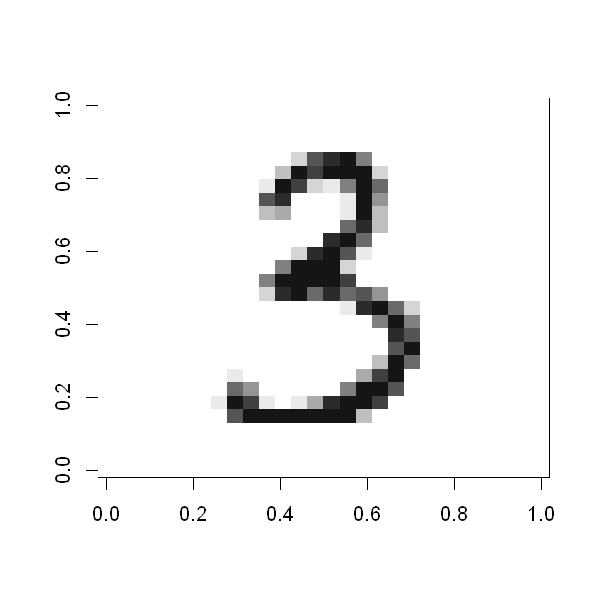

Warning message in matrix(as.matrix(arr784[-785]), nrow = 28):
"data length [785] is not a sub-multiple or multiple of the number of rows [28]"


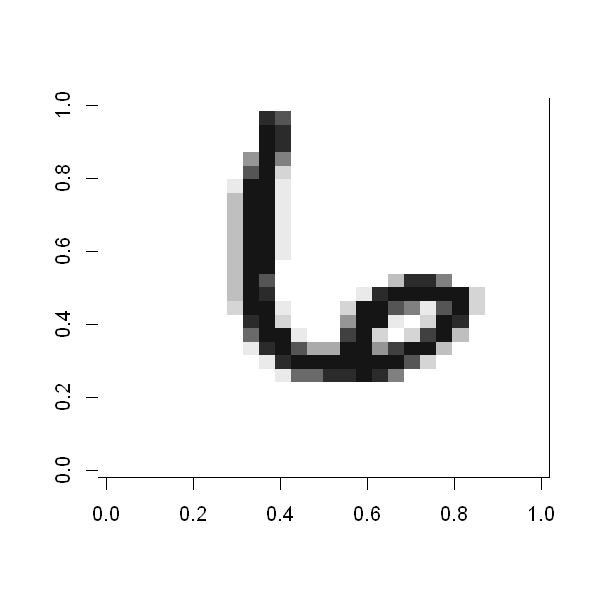

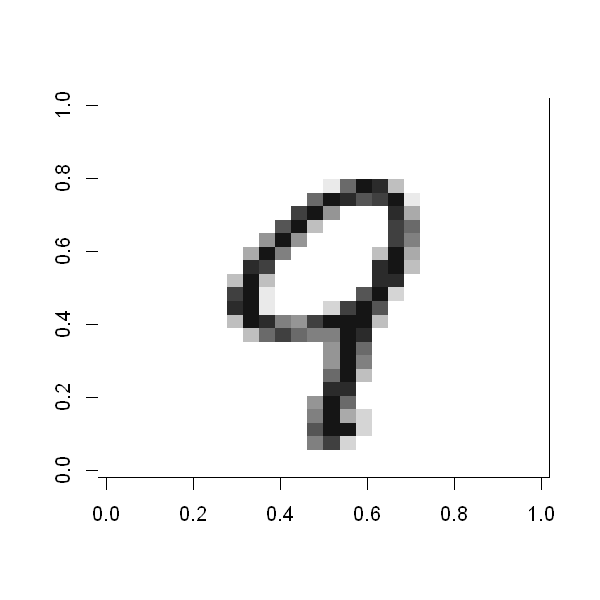

In [12]:
set.seed(666) 
options(repr.plot.height = 5, repr.plot.width = 5)

# Prepare k-NN predictions with labels for analysis
knn_predictions_with_labels <- knn_predictions |>
      select(.pred_class) |>
      bind_cols(testing_set |> select(y)) |>
      mutate(seq = 1:nrow(testing_set)) |>
      as.data.frame()

# Filter for correctly classified samples and randomly select 3 of them
matching <- knn_predictions_with_labels |>
         filter(.pred_class == y) |>
         sample_n(3)

# Extract the sequence numbers of the 3 matching rows
matching_1 <- matching |>
         slice(1) |>
         select(seq) |>
         pull()
matching_2 <- matching |>
         slice(2) |>
         select(seq) |>
         pull()
matching_3 <- matching |>
         slice(3) |>
         select(seq) |>
         pull()
matching

# Prepare the testing set for visualization
testing<-testing_set|>select(-X)

# Visualize the correctly classified digit images
show_digit(slice(testing,matching_1))
show_digit(slice(testing,matching_2))
show_digit(slice(testing,matching_3))